# 实验三 聚类技术---复杂网络社团检测

## 问题描述
复杂网络是描述复杂系统的有力工具，其中每个实体定义成一个节点，实体间的交互关系定义为边。复杂网络社团结构定义为内紧外松的拓扑结构，即一组节点的集合，集合内的节点交互紧密，与外界节点交互松散。复杂网络社团结构检测广泛的应用于信息推荐系统、致癌基因识别、数据挖掘等领域。

## 实验数据
本实验利用两类数据：模拟数据与真实数据。模拟数据有著名复杂网络学者Mark Newmann所提出，该网络包括128个节点，每个节点的度为16，网络包含4个社团结构，每个社团包含32个节点，每个节点与社团内部节点有k1个节点相互链接，与社团外部有k2个节点相互链接 （k1+k2=16）。通过调节参数k2 (k2=1,2,3,4,5,6,7,8)增加社团构建检测难度。

真实数据集：跆拳道俱乐部数据由34个节点组成，由于管理上的分歧，俱乐部分解成两个社团。

## 主要步骤如下

### 步骤一
导入网络数据；
         利用邻接矩阵A来存储网络，其中A_{ij}表示第i个节点与第j个节点的是否有边相互链接，
         1表示有，0表示没有



In [6]:
## 读取gml文件；画出网络结构图；返回一个邻接矩阵
def read_gml(filePath):
    G = nx.read_gml(filePath,label='id')
    # nx.draw(G,with_labels=True)
    # plt.show()
    return np.array(nx.adjacency_matrix(G).todense())

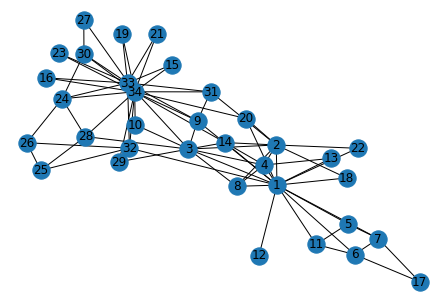

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
data = '.\exp3_data\karate.gml'
G = nx.read_gml(data,label='id')
nx.draw(G,with_labels=True)
plt.show()

In [8]:
import numpy as np
mat_A = np.array(nx.adjacency_matrix(G).todense())
mat_A,mat_A.shape

(array([[0, 1, 1, ..., 1, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 1],
        [0, 0, 1, ..., 1, 0, 1],
        [0, 0, 0, ..., 1, 1, 0]], dtype=int32),
 (34, 34))

### 步骤二
根据网络结构特征给出节点相似性度量指标；给定节点i, 其邻居节点定义为与该节点相链接的所有节点组成的集合，即 $ N(i)={j|A_{ij}=1,j=1,2,...,n}$给定一对节点$（i,j）$,其相似性定义为这个两个节点
        的公共邻居节点与邻居节点的并， 即：$S_{ij}=\frac{|N\left(i\right)\N\left(j\right)|}{|N(i)\N(j)|}$,

In [9]:
## 交
def set_cap(li,lj):
    l = len(li)
    cnt = 0
    for i in range(0,l):
        if li[i]==1 and lj[i]==1:cnt+=1
    return cnt
## 并
def set_cup(li,lj):
    l = len(li)
    cnt = 0
    for i in range(0,l):
        if li[i]==1 or lj[i]==1:cnt+=1
    return cnt
    

In [10]:
def Similarity(mat_A):
    m,n = mat_A.shape
    sim = np.zeros((m,n))
    for i in range(0,m):
        for j in range(i,n):
            sim[i,j] = set_cap(mat_A[i],mat_A[j])/set_cup(mat_A[i],mat_A[j])
            if i==j:sim[i,j] = 1
    return sim 
sim = np.zeros(mat_A.shape)
sim = Similarity(mat_A)
sim,sim.shape


(array([[1.        , 0.38888889, 0.23809524, ..., 0.        , 0.12      ,
         0.13793103],
        [0.        , 1.        , 0.26666667, ..., 0.07142857, 0.10526316,
         0.13043478],
        [0.        , 0.        , 1.        , ..., 0.23076923, 0.04761905,
         0.28571429],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        , 0.05882353,
         0.0952381 ],
        [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
         0.52631579],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.        ]]),
 (34, 34))

In [11]:
# 保存相似度矩阵结果
# import pandas as pd
# pd_sim = pd.DataFrame(sim)
# pd_sim.to_csv('.\exp3_data\sim.csv')

### 步骤三
采用贪婪算法提取模块
        随机选择一个未聚类的节点作为当前社团C，提取出社团C所有未聚类的邻居节
        点$N\left(C\right)$。选择使得社团密度降低最小的那个节点v添加到社团C，更新当前社团
        为$C=C\cup v$。持续该过程知道当前社团的密度小于某个阈值。


In [12]:
## 矩阵提取
def com_mat(sim,community):
    temp = sim[community]
    return temp[:,community]

In [13]:
## 计算社团内部的密度
def cal_density(mat_A,sim,community):
    ## 从小到大
    community.sort()
    
    ## 矩阵提取sim
    com_sim = com_mat(sim,community)
    
    ## 矩阵提取a
    com_a = com_mat(mat_A,community)
   
    if len(community)==1:return 1
    if np.sum(com_a)==0:return 0
    else: return np.average(com_sim) * np.sum(com_a) / len(community)

In [14]:
## 找到社团密度降低最小的那个节点 resNode:节点   density:计算好的密度
def findBestdensity(community,nextNode,mat_A,sim,isIncommunity):
    density_list = np.zeros(mat_A[nextNode].shape[0])
    for node in range(0,mat_A[nextNode].shape[0]):
        copyCom = community.copy()
        if node == nextNode:continue
        if mat_A[nextNode][node]==1 and isIncommunity[node]==0:
            copyCom.append(node)
            density_list[node] = cal_density(mat_A,sim,copyCom)
            copyCom.clear()
    resNode = np.argsort(density_list)[::-1][0]
    density = density_list[resNode]
    return resNode,density

In [15]:
## 贪心提取模块
def greedy_cluster(mat_A,sim,threshold,begin_node):
    ## 社团
    density = 1
    community = []
    isIncommunity = np.zeros(mat_A.shape[0])
    ## 初始节点
    nextNode = begin_node
    # print(nextNode)
    community.append(nextNode)
    isIncommunity[nextNode] = 1

    while density > threshold:
        nextNode,density = findBestdensity(community,nextNode,mat_A,sim,isIncommunity)
        if density < threshold:break
        # print(nextNode,density)
        community.append(nextNode)
        isIncommunity[nextNode] = 1
    return community,density

In [16]:
## 打印所有节点贪心提取模块输出
for i in range(0,34):
    res_cluster,density = greedy_cluster(mat_A,sim,0.5,i)
    print("节点:",i,res_cluster)


节点: 0 [0, 1, 3, 7, 2, 13, 33, 19]
节点: 1 [1, 0, 3, 7, 2, 13, 33, 19]
节点: 2 [2, 3, 7, 1, 0, 13, 33, 19]
节点: 3 [3, 7, 1, 2, 0, 13, 33, 19]
节点: 4 [4, 10, 0, 5, 6, 16]
节点: 5 [5, 6, 16]
节点: 6 [6, 5, 16]
节点: 7 [7, 3, 1, 2, 0, 13, 33, 19]
节点: 8 [8, 30, 32, 33, 22]
节点: 9 [9, 33]
节点: 10 [10, 4, 0, 5, 6, 16]
节点: 11 [11, 0]
节点: 12 [12, 3, 0, 7, 1, 2, 13, 33, 19]
节点: 13 [13, 3, 1, 2, 0, 7]
节点: 14 [14, 32, 33, 22]
节点: 15 [15, 32, 33, 22]
节点: 16 [16, 5, 6, 0, 4, 10]
节点: 17 [17, 1, 0, 21]
节点: 18 [18, 32, 33, 22]
节点: 19 [19, 1, 0, 13, 3, 2, 7]
节点: 20 [20, 32, 33, 22]
节点: 21 [21, 1, 0, 17]
节点: 22 [22, 32, 33, 15]
节点: 23 [23, 29, 33, 32, 14]
节点: 24 [24, 25, 31, 28, 33, 27, 23, 32, 29, 26]
节点: 25 [25, 24, 31, 28, 33, 27, 23, 32, 29, 26]
节点: 26 [26, 29, 33, 23, 32, 14]
节点: 27 [27, 23, 33, 32, 29, 26]
节点: 28 [28, 31, 33, 32, 8, 30, 1, 2, 0, 13, 3, 7]
节点: 29 [29, 23, 33, 32, 14]
节点: 30 [30, 8, 32, 33, 22]
节点: 31 [31, 28, 33, 32, 8, 30, 1, 2, 0, 13, 3, 7]
节点: 32 [32, 33, 8, 30, 1, 2, 13, 0, 3, 7]
节点: 33 [33, 

### 步骤四
可视化聚类结果。

In [17]:
def create_com(res_cluster):
    com1 = list((np.array(res_cluster) + 1))
    com2 = [i for i in G.nodes if i not in com1]
    return com1,com2

In [18]:
def draw_res(com1,com2):

    all_nodes = com1 + com2
    elist = [e for e in G.edges]
    G2 = nx.Graph()
    for n in all_nodes:
        G2.add_node(n)
    for from_loc, to_loc in elist:
        G2.add_edge(from_loc, to_loc)   

    pos = nx.spring_layout(G2) 
    nx.draw(G2, pos, edge_color='k',  with_labels=True,
            font_weight='light', node_size= 280, width= 0.9)

    nx.draw_networkx_nodes(G2, pos, nodelist=com1, node_color='g',alpha=0.7)
    nx.draw_networkx_nodes(G2, pos, nodelist=com2, node_color='r',alpha=0.7)
    plt.show()

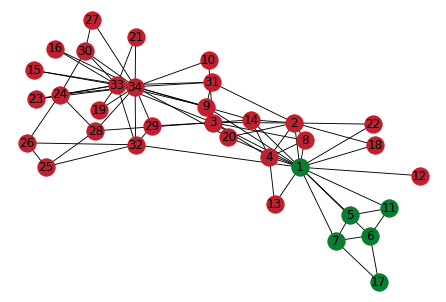

起始节点: 17


In [42]:
## 邻接矩阵，关系度矩阵，阈值，随机起始节点
begin_node = np.random.randint(mat_A.shape[0])
res_cluster,density = greedy_cluster(mat_A,sim,0.5,begin_node)
com1,com2 = create_com(res_cluster)
draw_res(com1,com2)
print("起始节点:",begin_node+1)